In [41]:
%matplotlib inline
import pathlib as pl
import numpy as np
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import rasterio.warp
from shapely.geometry import shape

import scipy.sparse as sparse

import flopy
import flopy.plot.styles as styles

from gdptools import WeightGenP2P

In [42]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, get_dflow_grid_name, get_modflow_coupling_tag, get_modflow_grid_name

In [43]:
control_path = pl.Path("../dflow-fm/coarse/tides_2018/base/FlowFM.mdu") # change this if using a different D-Flow FM control file
grid_name = get_dflow_grid_name(control_path)
print(grid_name)


LIS_GPT_PJ_cells3_net


In [44]:
# mf_grid_name = get_modflow_grid_name()
# print(mf_grid_name)

In [45]:
get_modflow_coupling_tag(1.)

'01.00H'

## Read the D-Flow FM output file

Make sure you run D-Flow FM by itself first so that there is an output NetCDF file available so that the mapping is done using the internal node order

In [46]:
# use an output file because this is what will be available from bmi and is in the correct order
source_path = "../dflow-fm/coarse/tides_2018/FlowFM_map.nc"
source_ds = xugrid.open_dataset(source_path)


In [47]:
source_ds

<xarray.Dataset> Size: 8GB
Dimensions:                      (mesh2d_nNodes: 13365, mesh2d_nEdges: 35029,
                                  mesh2d_nFaces: 21660,
                                  mesh2d_nMax_face_nodes: 4, time: 1513)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 107kB ...
    mesh2d_node_y                (mesh2d_nNodes) float64 107kB ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 280kB ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 280kB ...
    mesh2d_face_x                (mesh2d_nFaces) float64 173kB ...
    mesh2d_face_y                (mesh2d_nFaces) float64 173kB ...
  * time                         (time) datetime64[ns] 12kB 2010-03-01 ... 20...
  * mesh2d_nEdges                (mesh2d_nEdges) int64 280kB 0 1 ... 35027 35028
  * mesh2d_nNodes                (mesh2d_nNodes) int64 107kB 0 1 ... 13363 13364
  * mesh2d_nFaces                (mesh2d_nFaces) int64 173kB 0 1 ... 21658 21659
Dimensions without coordinates: mesh2d_nMax_face_nodes
Data variables: (12/32)
    projected_coordinate_system  int32 4B ...
    mesh2d_node_z                (mesh2d_nNodes) float64 107kB ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 693kB ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 693kB ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 280kB ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 173kB ...
    ...                           ...
    mesh2d_cfutyp                (time, mesh2d_nEdges) float64 424MB ...
    mesh2d_Patm                  (time, mesh2d_nFaces) float64 262MB ...
    mesh2d_windx                 (time, mesh2d_nFaces) float64 262MB ...
    mesh2d_windy                 (time, mesh2d_nFaces) float64 262MB ...
    mesh2d_windxu                (time, mesh2d_nEdges) float64 424MB ...
    mesh2d_windyu                (time, mesh2d_nEdges) float64 424MB ...
Attributes:
    institution:               Deltares
    references:                http://www.deltares.nl
    source:                    D-Flow FM 1.2.177.142431. Model:
    history:                   Created on 2025-07-28T10:24:02-0400, D-Flow FM
    date_created:              2025-07-28T10:24:02-0400
    date_modified:             2025-07-28T10:24:02-0400
    Conventions:               CF-1.8 UGRID-1.0 Deltares-0.10 ACDD-1.3
    uuid:                      669f71b0-72e3-0842-a504-c2d0fe654e99
    time_coverage_start:       2010-03-01T**:00:00+00:00
    time_coverage_end:         2010-03-22T**:00:00+00:00
    time_coverage_duration:    P0000-00-21T00:00:00
    time_coverage_resolution:  P0000-00-00T00:20:00

In [48]:
print(source_ds.grid.face_node_connectivity.shape)
source_ds.grid.face_node_connectivity

(21660, 4)


array([[13296,     0,     1,  -999],
       [    3,     2,     0,  -999],
       [    1,     0,     2,  -999],
       ...,
       [13295, 13291, 13287, 13293],
       [13288, 13291, 13290, 13286],
       [13295, 13294, 13290, 13291]], dtype=int64)

In [49]:
print(source_ds.grid.node_face_connectivity.shape)
source_ds.grid.node_face_connectivity

(13365, 21660)


<13365x21660 sparse matrix of type '<class 'numpy.int32'>'
	with 68795 stored elements in Compressed Sparse Row format>

### Convert the NetCDF data to a geodataframe

In [50]:
source_gdf = source_ds["mesh2d_nFaces"].ugrid.to_geodataframe(name="cell")

In [51]:
source_gdf.set_crs(32618, inplace=True)

cell  mesh2d_face_x  mesh2d_face_y  \
mesh2d_nFaces                                        
0                  0  581304.782862   4.530140e+06   
1                  1  580948.525069   4.529244e+06   
2                  2  581165.501727   4.529318e+06   
3                  3  580708.393782   4.528634e+06   
4                  4  581718.153967   4.528955e+06   
...              ...            ...            ...   
21655          21655  698004.338382   4.540132e+06   
21656          21656  698641.288943   4.539406e+06   
21657          21657  697760.020796   4.539259e+06   
21658          21658  698114.810029   4.539777e+06   
21659          21659  698198.803558   4.539314e+06   

                                                        geometry  
mesh2d_nFaces                                                     
0              POLYGON ((581278.095 4530797.658, 580803.668 4...  
1              POLYGON ((580509.155 4529024.860, 581120.782 4...  
2              POLYGON ((581637.189 4529571.190, 580803.668 4...  
3              POLYGON ((580509.155 4529024.860, 580305.524 4...  
4              POLYGON ((581930.574 4528371.125, 581637.189 4...  
...                                                          ...  
21655          POLYGON ((697883.097 4539946.737, 698216.083 4...  
21656          POLYGON ((698946.834 4539209.344, 698783.296 4...  
21657          POLYGON ((698001.058 4539041.376, 697939.776 4...  
21658          POLYGON ((697883.097 4539946.737, 697939.776 4...  
21659          POLYGON ((698001.058 4539041.376, 698454.277 4...  

[21660 rows x 4 columns]

In [52]:
print(source_gdf.crs)

EPSG:32618


## Open the shapefile with the location of the coastal boundaries in MODFLOW

The shapefile needs to be limited to coastal boundary locations and be in the same coordinate system as the D-Flow FM model (UTM 18N).

In [53]:
fpth = f"../modflow/gis/PJ/PJ_CHD_utm18n.shp"
print(fpth)

../modflow/gis/PJ/PJ_CHD_utm18n.shp


In [54]:
target_coastal = gpd.read_file(fpth) # this is the shapefile with coastal boundary conditions
a = target_coastal.explore()


dflowdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(source_ds.mesh2d_node_x , source_ds.mesh2d_node_y), crs = 'EPSG:32618')
dflowdf.explore(m=a)

In [55]:
target_coastal.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

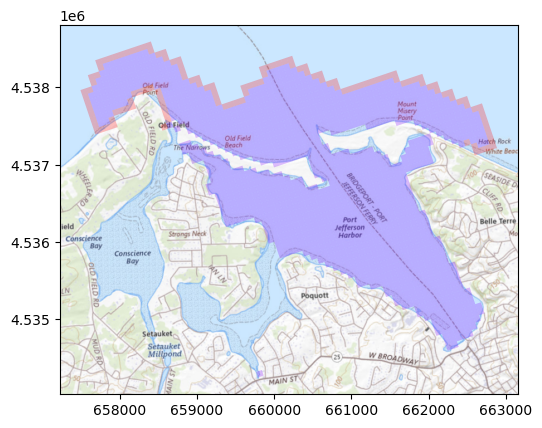

In [56]:
ax = target_coastal.plot(alpha=0.25, column="boundname", cmap= 'rainbow')
cx.add_basemap(ax, crs=target_coastal.crs, attribution=False, source=cx_provider)

## Create the D-FLOW FM to CHD mapping

In [57]:
# generate the weights
weight_gen = WeightGenP2P(
    target_poly=target_coastal,
    target_poly_idx="chd_no",
    source_poly=source_gdf,
    source_poly_idx=["cell"],
    method="serial",
    weight_gen_crs=32618,
)
weights = weight_gen.calculate_weights()


Using serial engine
Reprojecting to epsg:EPSG:32618 finished in 0.0 second(s)
Validating polygons
     - validating source polygons
     - fixing 0 invalid polygons.
     - validating target polygons
     - fixing 0 invalid polygons.
Validate polygons finished in 0.0319 seconds
Intersections finished in 0.0827 seconds
Weight gen finished in 0.1153 seconds


In [58]:
weights[:12]
# len(weights)

chd_no   cell      wght
0       0  12149  0.102531
1       0  12312  0.046842
2       0  11988  0.256401
3       0  12476  0.047196
4       0  12315  0.194599
5       0  12152  0.352431
6       1  11988  0.337168
7       1  12152  0.662832
8       2  11988  0.266078
9       2  12152  0.733922
10      3  11988  0.194988
11      3  12152  0.805012

In [59]:
map_shape = (target_coastal.shape[0], source_gdf.shape[0])
map_shape

(1462, 21660)

In [60]:
dflow2mfchd = np.zeros(map_shape, dtype=float)
print(f"{dflow2mfchd.shape}\n{dflow2mfchd}")

(1462, 21660)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [76]:
check.shape

(1462,)

In [61]:
for r,c,v in zip(weights["chd_no"], weights["cell"], weights["wght"]):
    print(r,c,v)
    dflow2mfchd[int(float(r)),int(c)] = v

check = weights['chd_no'].drop_duplicates()
assert len(check) == target_coastal.shape[0]

0 12149 0.10253131966710771
0 12312 0.04684196763489528
0 11988 0.2564006533323245
0 12476 0.04719592741921134
0 12315 0.1945992802373454
0 12152 0.3524308517073781
1 11988 0.3371684708132452
1 12152 0.662831529187494
2 11988 0.2660781096188688
2 12152 0.7339218903809446
3 11988 0.1949876676596048
3 12152 0.8050123323402674
4 11988 0.059806981180001724
4 11824 0.009145136545972
4 11825 0.04809557989540842
4 12152 0.20271928181464888
4 11989 0.22935971057694798
4 12153 0.45087330998663283
5 11825 0.01707518962089294
5 11989 0.9796933810318097
5 12153 0.0032314293474141427
6 11989 0.9999999999999999
7 11989 0.9999999999999999
8 12149 0.3177793059601551
8 12312 0.6822206940415801
9 12149 0.7279998370581283
9 11988 0.2720001629439969
10 11988 1.0000000000000002
11 11988 1.0000000000000002
12 11988 0.9377334388150337
12 11824 0.06226656118454674
13 11988 0.10471206829661521
13 11824 0.6473837497494607
13 11825 0.24790418195356026
14 11825 0.9876087991413505
14 11989 0.012391200857567345
15 

## Create the chd masking array

Where the sums of the weights along a row are not equal to ~1.0

In [62]:
mask_idx = np.isclose(dflow2mfchd.sum(axis=1), 1.0)
print(f"{mask_idx.sum()}\n{mask_idx.shape}\n{mask_idx}")


print(target_coastal.shape[0], mask_idx.shape[0])
assert mask_idx.shape[0] == target_coastal.shape[0]


# Print indices of rows where the condition is False
false_rows = np.where(~mask_idx)[0]
print("Rows where the sum is NOT close to 1.0:")
print(false_rows)

f = dflow2mfchd[false_rows]
f = dflow2mfchd[false_rows].sum()
f

1462
(1462,)
[ True  True  True ...  True  True  True]
1462 1462
Rows where the sum is NOT close to 1.0:
[]


0.0

### Test the D-FLOW FM to CHD mapping

In [63]:
s = np.full(source_gdf.shape[0], 1.0)
h = np.full(mask_idx.shape, 2.0)
h[mask_idx] = dflow2mfchd.dot(s)[mask_idx]
s.shape, dflow2mfchd.shape, h.shape

((21660,), (1462, 21660), (1462,))

In [64]:
print(f"{h.sum()}\n{h}")

1462.0000000000327
[1. 1. 1. ... 1. 1. 1.]


#### Test with a nan

In [65]:
s = np.random.random(source_gdf.shape[0])
s[1544] = -1e30
print(s)

[0.60242258 0.39923895 0.82096832 ... 0.18223005 0.48973993 0.07853627]


In [66]:
h = np.full(mask_idx.shape, 2.0)
h = dflow2mfchd.dot(s)
h.shape

(1462,)

In [67]:
print(f"{h.sum()}\n{h}")

713.091952964802
[0.70054474 0.87270634 0.86816545 ... 0.39863464 0.5145263  0.30020589]


## Create the CHD to Qext mapping

In [68]:
chd2qext = np.transpose(dflow2mfchd.copy())

### Test the CHD to Qext mapping

In [69]:
q = np.full(chd2qext.shape[1], 1.0)

In [70]:
qext = chd2qext.dot(q)

In [71]:
print(f"{qext.sum()}\n{qext.shape}")

1462.0000000000327
(21660,)


## Save the mapping arrays

In [72]:
print(target_coastal.shape[0], source_gdf.shape[0])
assert dflow2mfchd.shape == (target_coastal.shape[0], source_gdf.shape[0])

1462 21660


In [73]:
print(mask_idx.shape[0])
assert mask_idx.shape[0] == target_coastal.shape[0]

1462


In [74]:
assert chd2qext.shape == (source_gdf.shape[0], target_coastal.shape[0])
print(source_gdf.shape[0], target_coastal.shape[0])

21660 1462


In [75]:
mf_grid_name = 'PJmf6'
fpath = f"../mapping/PJ/dflow_{grid_name}_to_{mf_grid_name}_chd.npz"
np.savez_compressed(fpath, dflow2mfchd=dflow2mfchd, chdmask=mask_idx, chd2qext=chd2qext)